<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/4_Factor%20Analysis%20Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collection of factor analysis techniques

### What's in the notebook?
This notebook contains a collection of commonly used research techniques in factor analysis.

### Is this the only way to do research ?
No this list is not exahustive by any means, but it's what we often use in RobotWealth.


What you'll see are simple, robust  yet powerful analysis techniques, mastering the nuances between them will help you (dis)prove market hypotheses quickly and efficiently. 


For the sake of simplicity, we are going to test out all our research methods on one factor, and on a single instrument.


The factor we'll use is previous days returns.

So our hypothesis becomes: _"Previous day returns have predictive ability over next day returns"_

This is what we'll try to disporve.

Since we've been actively involved in the crypto markets lately, I'll pick BTC prices and only run analysis on that




# Techniques we will look at

 - Scatterplot 
 - Factor plot (group by factor, plot aggregated target per group)
 - Conditional Distributions
 - Information ratio (correlation of factor to target)


### Load libraries and data

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmphW8GAd/remotese16031da2/RWLab-rwRtools-1924b0b/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
  NB: this package now depends on R (>= 3.5.0)
  serialize/load version 3 cannot be read in older versions of R.
  File(s) containing such objects:
    ‘rwRtools/R/sysdata.rda’
* building ‘rwRtools_0.1.33.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto quickstart v.0.1
quicksetup(pod = "Crypto", path = ".")
prices %>% 
  head()


Set default bucket name to 'crypto_research_pod'



Attempting download of  coinmetrics.csv ...
Transferring coinmetrics.csv ... data is 2.4 Mb please be patient...


ℹ Downloading coinmetrics.csv

✔ Saved coinmetrics.csv to ./coinmetrics.csv  ( 2.4 Mb )





coinmetrics.csv successfully transferred


Rows: 49183 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ticker
dbl  (2): price_usd, market_cap
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


prices data object transferred and loaded as data.frame to Global Env


ticker,date,price_usd,market_cap
<chr>,<date>,<dbl>,<dbl>
1INCH,2020-12-26,1.6193281,2428992153
1INCH,2020-12-27,1.0723502,1608525301
1INCH,2020-12-28,1.1046742,1657011227
1INCH,2020-12-29,0.8937904,1340685538
1INCH,2020-12-30,1.1013066,1651959828
1INCH,2020-12-31,1.3652374,2047856106


In [4]:
#Create test data with a strong linear relationship

test_data <- data.frame(
  feature = c(1,2,3,4,5,6,7,8,9,10), target = c(-5,-4,-3,-2,-1,1,2,3,4,5)
)

### Calculating the feature



In [5]:
btc <- prices %>%
  filter(ticker == "BTC") %>%
  arrange(date) %>%
  mutate(
    feature = log(price_usd/lag(price_usd, n = 1)),
    target = lead(feature, n =1)
  ) %>% 
  ungroup() %>%
  na.omit() 

head(btc)

ticker,date,price_usd,market_cap,feature,target
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-19,0.08080000,279285.2,-0.06050813,-0.07801869
BTC,2010-07-20,0.07473573,259000.4,-0.07801869,0.05792790
BTC,2010-07-21,0.07919286,275266.5,0.05792790,-0.30337647
BTC,2010-07-22,0.05846976,203749.6,-0.30337647,0.03566752
BTC,2010-07-23,0.06059287,211735.7,0.03566752,-0.10524285
BTC,2010-07-24,0.05454000,191100.0,-0.10524285,-0.07615704


## 1. Scatter plot

A scatter plot uses points to represent the data.

You can use this method when you want to see a relationship between two numeric variables.

In this case the question we are looking to answer with a scatter plot is: 

**"Given a value of my X variable (previous days return) what is the expected value of the Y variable (next day returns)"**

It is also very common to combine the scatter plot with a linear fit line, as this can make the relationship stand out when there is no clear pattern (as is the case in finance)

`geom_smooth()` using formula = 'y ~ x'


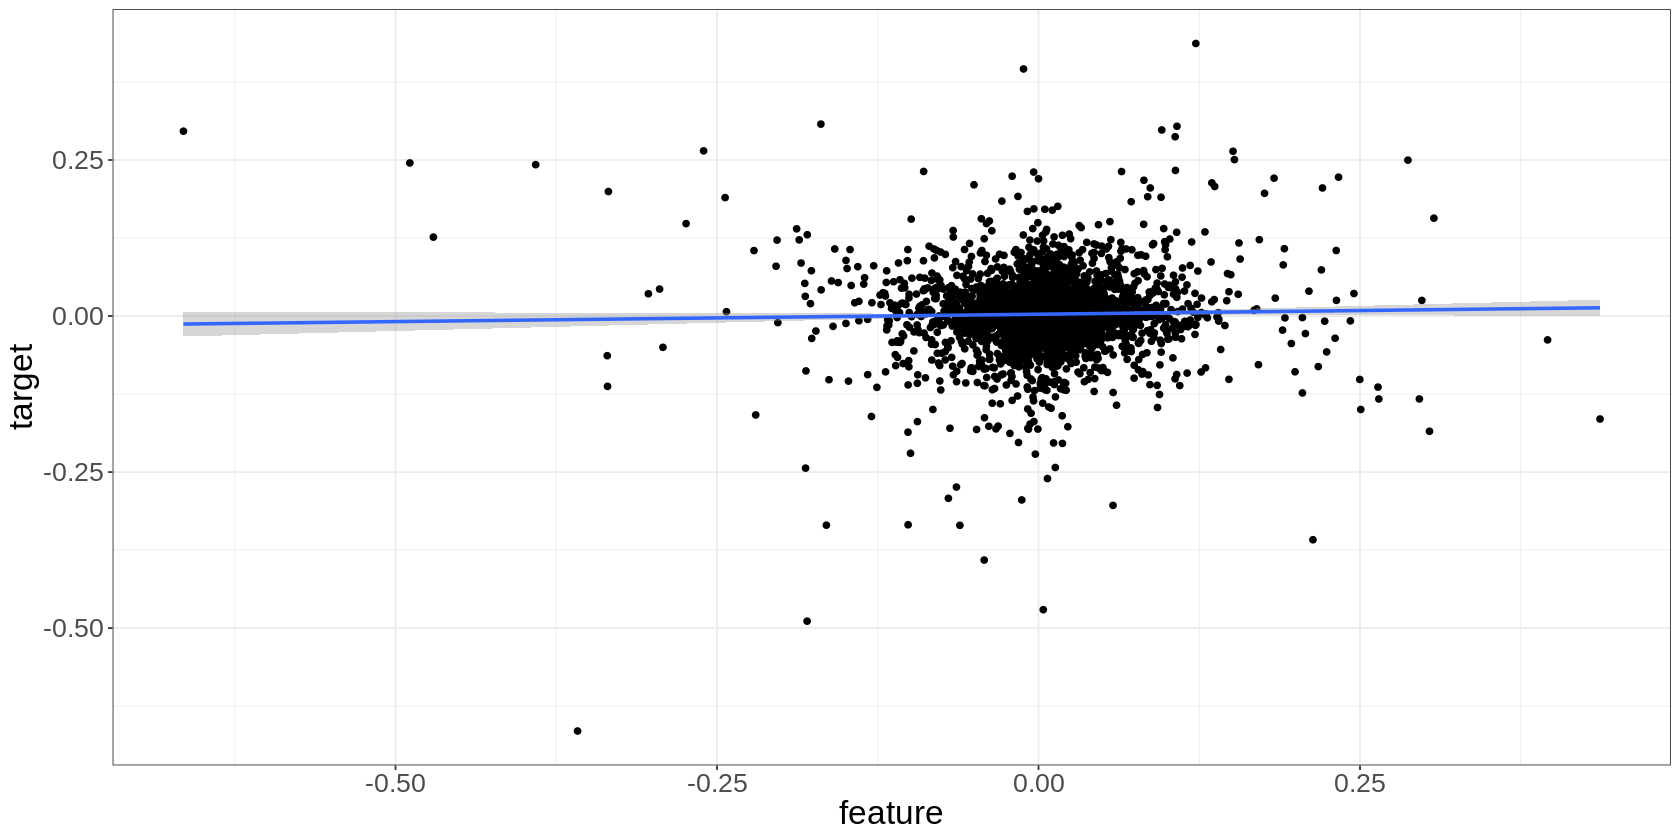

In [6]:
btc %>% 
  ggplot(aes(x = feature, y = target)) + 
  geom_point() + 
  geom_smooth(method = 'lm') #Adding a linear regression line


In this particular case we can see a **very** small positive relationship between our feature and target.

Scatter plots are good, but they get hard to interpret when the relationships are super nosiy, and plotting performance becomes an issue on big datasets.

The way you know you have a strong relationship at hand is by looking at the direction that the points go to, as you move left to right on your X axis

Also the slope of the linear regression line helps with this.


Here is how a perfect signal could look like (only for demonstration, highly unlikely you'll ever see something like this in finance)

`geom_smooth()` using formula = 'y ~ x'


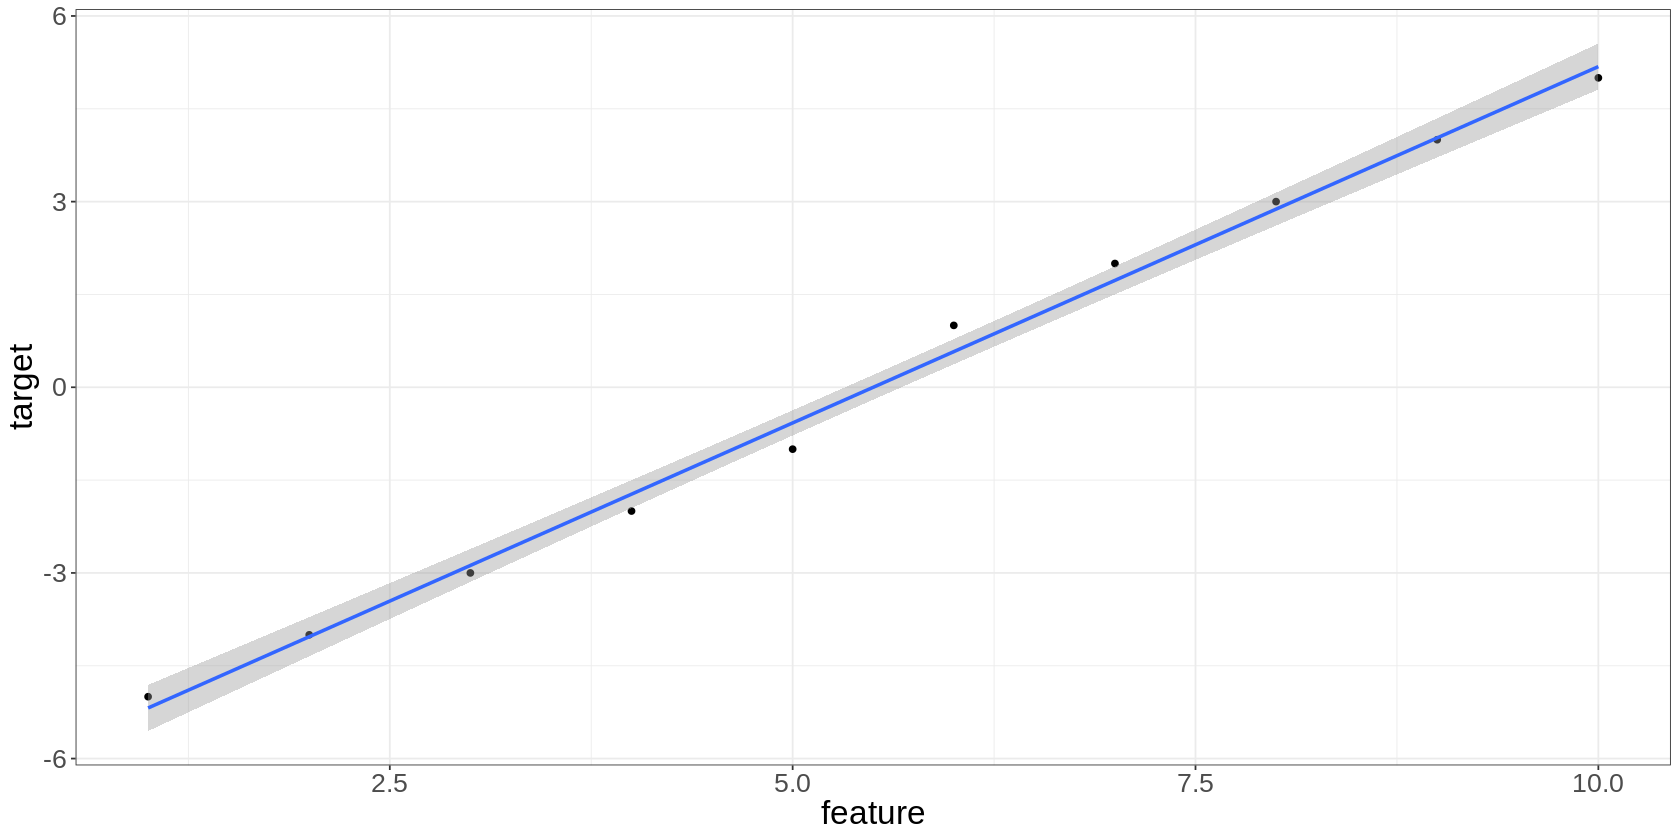

In [7]:
test_data %>% 
  ggplot(aes(x = feature, y = target)) + 
  geom_point() + 
  geom_smooth(method = 'lm') #Adding a linear regression line

## 2. Factor Plot

There are multiple ways to plot a factor plot 

But at its core a factor plot is showing how your metric of choice evolves through different types of categories of a factor plot. 

Because our feature is continuous, we're going to divide it into different categories. We're going to do that by simply taking their distribution and assigning a bin which they belong to based on their value

Here we are going to define our factor as the bin which a feature falls in, and our metric is going to be the mean of our target for each of those bins.

In this particular case there is a flaw with this analysis, because we are assuming that we knew the distribution of returns (when we divide our feature in different Ntiles) from day 1 (which we couldn't have) but let's ignore that for simplicity.

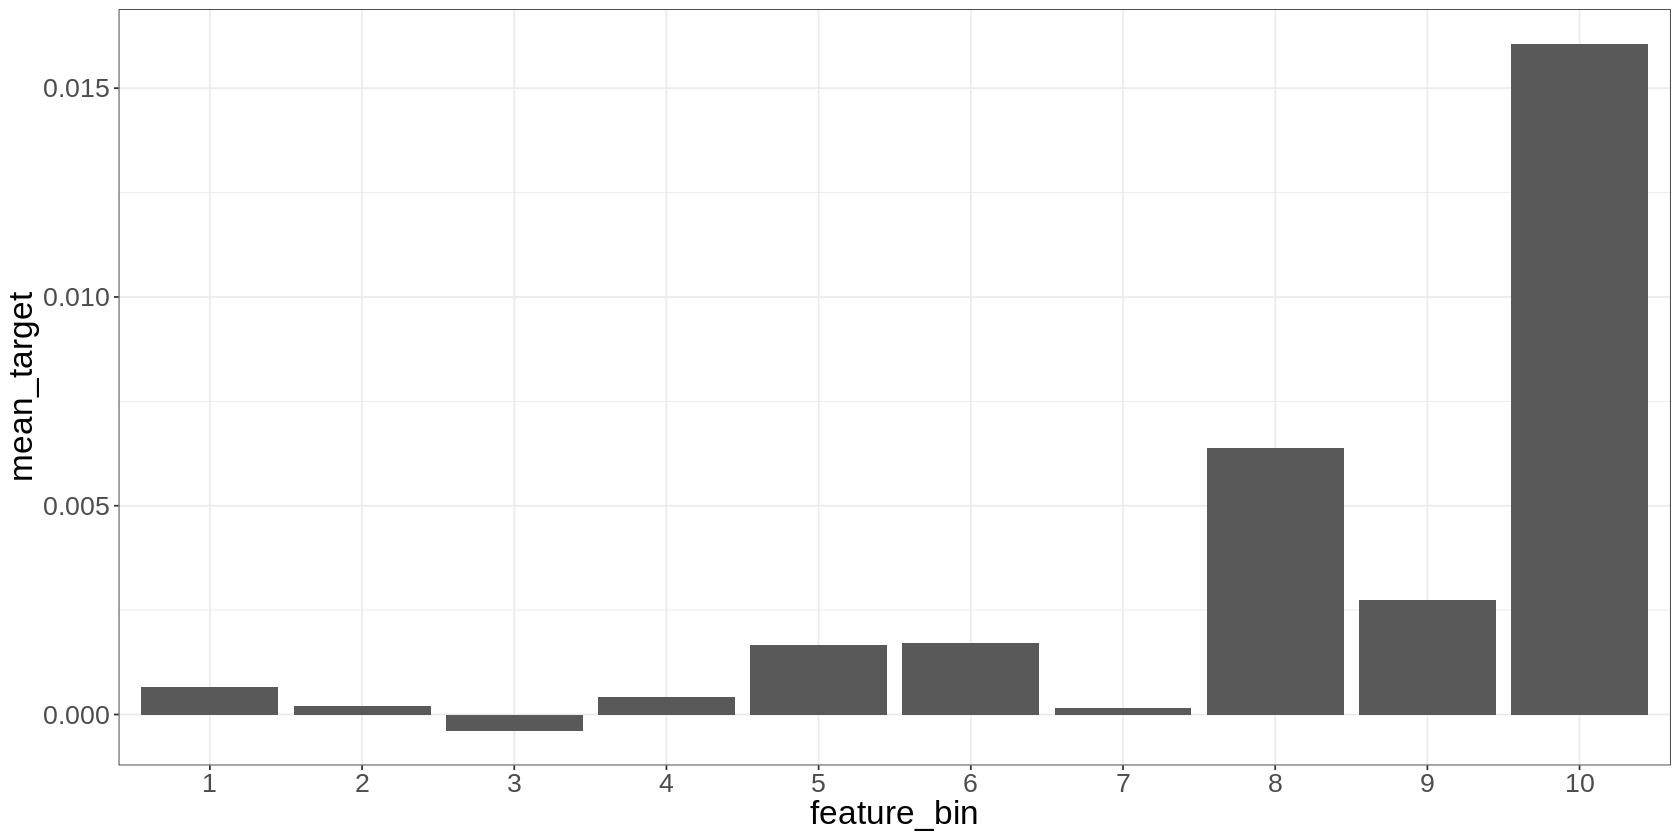

In [8]:
btc %>% 
  mutate(feature_bin = as.factor(ntile(feature,n=10))) %>%
  group_by(feature_bin) %>%
  summarise(mean_target = mean(target)) %>%
  ggplot(aes(x = feature_bin, y = mean_target)) + 
  geom_bar(stat = 'identity') 

This plot also confirms what the scatter plot showed, but now the signal is 
magnified, and easier to spot.

What we're looking for here is a monotonic change of our target across the bins, only the most obvious of patterns count. 

Another sign of quality in your signal is the range of your target value from the lowest to highest bin - Not always however, often times in real life there,are  non linear relationships at the extremes which make this plot a bit hard to interpret

For reference here is how a **perfect** positve relationship factor plot looks like.

If you ever see this in finance, then go back and figure out what you messed up. 

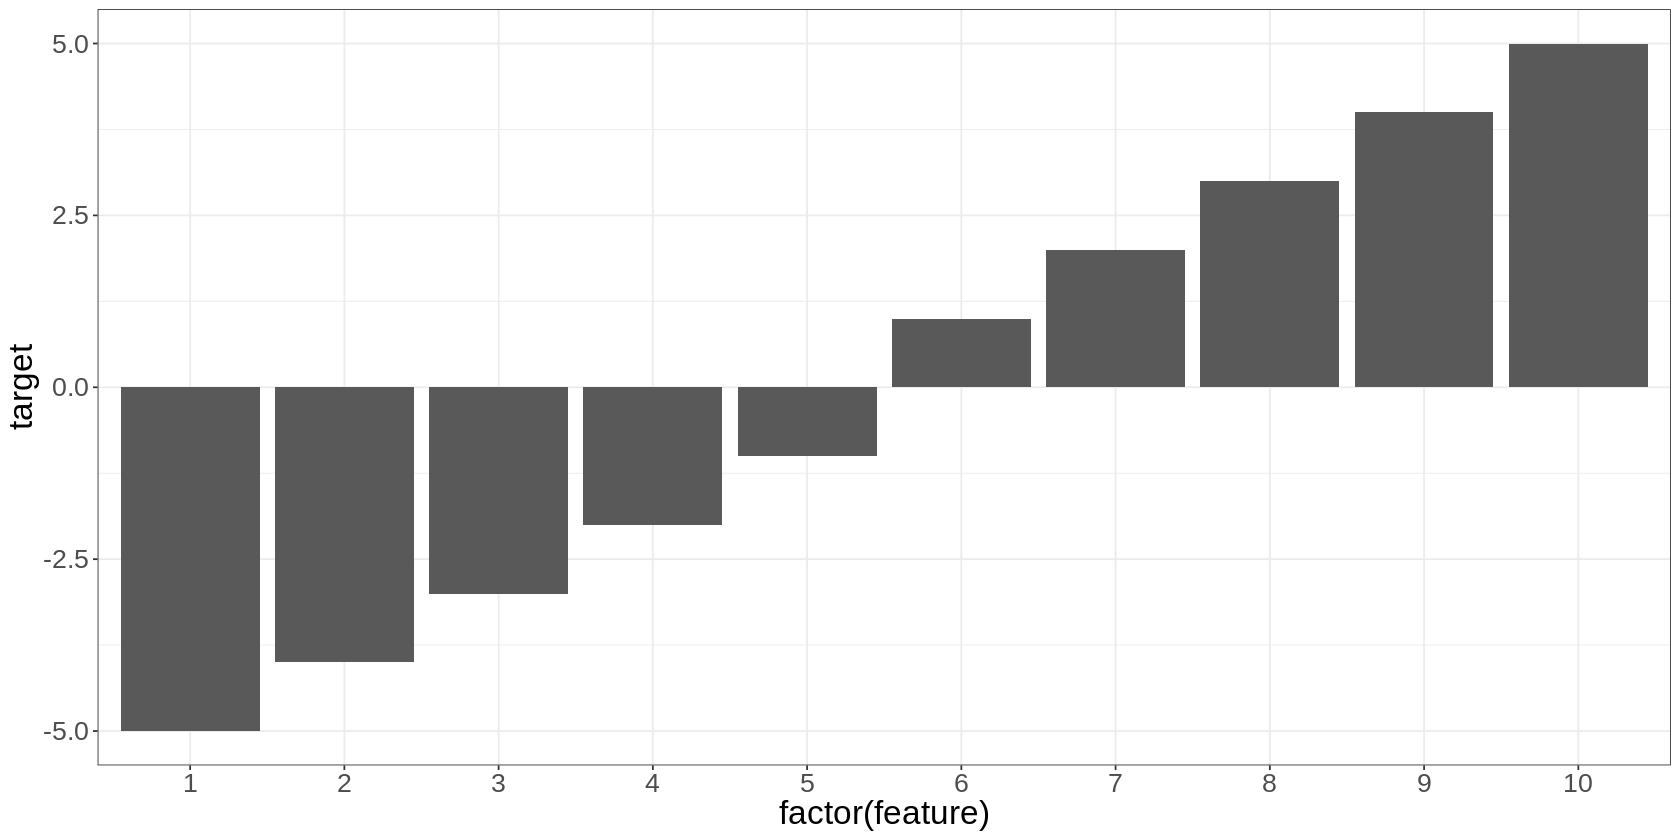

In [9]:
test_data %>%
  ggplot(aes(x = factor(feature), y = target)) +
  geom_bar(stat='identity')

## 3. Conditional Distributions

As we saw above, the factor plot is a capable analytical tool, it will take a nosiy signal and condense it down. 

There is one flaw with the factor plot as we defined it however.


In the first plot we aggregated our target by taking the mean of it for each bucket that the feature belonged to.

The issue here is that calculations like the mean can get easily skewed by a few large observations, this can have a dramatic effect on the shape of our plots, especially around the extremes.

A neat way to go around that is to plot the target distribution, for each bucket, instead of aggregating it.

From there we'll have a nice view into all the moments of the distribution

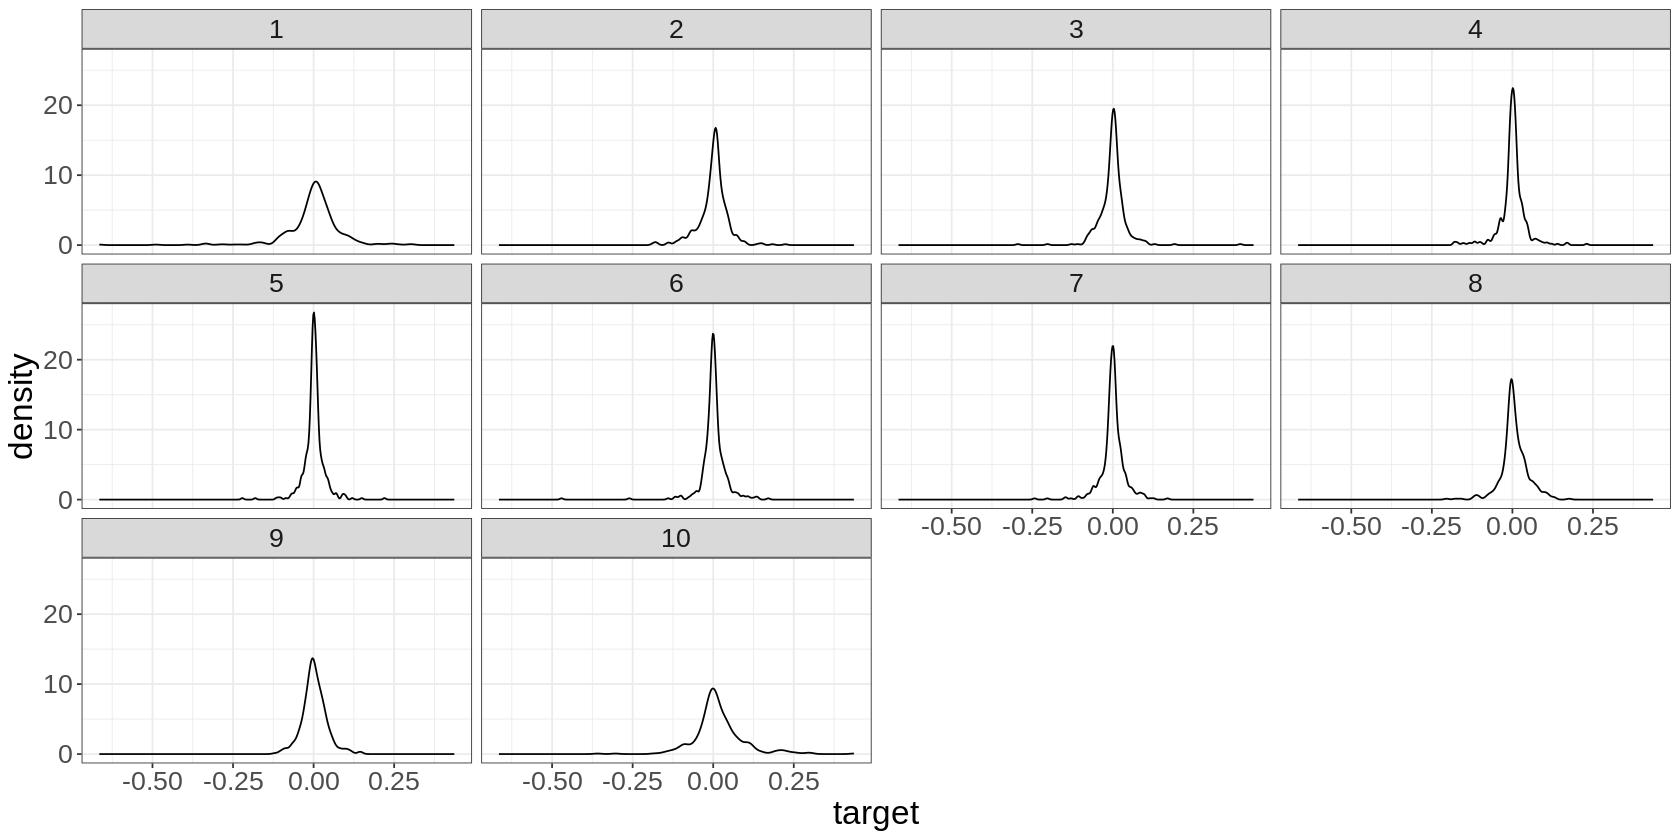

In [10]:
btc %>% 
  mutate(feature_bin = as.factor(ntile(feature,n=10))) %>%
  ggplot(aes(x = target)) +
  geom_density() +
  facet_wrap(~feature_bin)

## 4. Information Coefficient

Or how correlated is your feature to your target

This method is really useful when you need to quantify and standardize your features. 

Although it can be used in many more ways then what we'll show here, to keep it short, we're going to use the IC as a means of testing the stability of the factor specifications.

First testing the a single factor



In [11]:
btc %>%
  summarise(information_coefficient = cor(feature,target))

information_coefficient
<dbl>
0.02362306


Now let's make a few more factors of the same type, but with different lookbacks. This method is useful for determining our parameter stability/luck, don't use this for optimizing

In [12]:
#Calculate multiple factors
multiple_factors <- prices %>%
  filter(ticker == "BTC") %>%
  arrange(date) %>%
  mutate(
    '1' = log(price_usd/lag(price_usd, n = 1)),
    '2' = log(price_usd/lag(price_usd, n = 2)),
    '3' = log(price_usd/lag(price_usd, n = 3)),
    '4' = log(price_usd/lag(price_usd, n = 4)),
    '5' = log(price_usd/lag(price_usd, n = 5)),
    '6' = log(price_usd/lag(price_usd, n = 6)),
    '7' = log(price_usd/lag(price_usd, n = 7)),
    '8' = log(price_usd/lag(price_usd, n = 8)),
    '9' = log(price_usd/lag(price_usd, n = 9)),
    '10' = log(price_usd/lag(price_usd, n = 10)),
    target = lead(`1`, n =1)
  ) %>% 
  ungroup() %>%
  na.omit() 

head(multiple_factors)


ticker,date,price_usd,market_cap,1,2,3,4,5,6,7,8,9,10,target
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BTC,2010-07-28,0.05891110,208769.2,0.004919175,0.05067782,0.15325217,0.07709513,-0.02814772,0.007519803,-0.29585667,-0.2379288,-0.315947458,-0.376455591,0.1710361422
BTC,2010-07-29,0.06990000,248340.7,0.171036142,0.17595532,0.22171396,0.32428831,0.24813127,0.142888425,0.17855595,-0.1248205,-0.066892626,-0.144911316,-0.0779633719
BTC,2010-07-30,0.06465738,230303.1,-0.077963372,0.09307277,0.09799195,0.14375059,0.24632494,0.170167900,0.06492505,0.1005926,-0.202783899,-0.144855998,0.0437035934
BTC,2010-07-31,0.06754580,241277.0,0.043703593,-0.03425978,0.13677636,0.14169554,0.18745418,0.290028534,0.21387149,0.1086286,0.144296167,-0.159080306,-0.1002940046
BTC,2010-08-01,0.06110000,218982.4,-0.100294005,-0.05659041,-0.13455378,0.03648236,0.04140153,0.087160175,0.18973453,0.1135775,0.008334642,0.044002162,-0.0181673040
BTC,2010-08-02,0.06000000,215766.0,-0.018167304,-0.11846131,-0.07475772,-0.15272109,0.01831506,0.023234230,0.06899287,0.1715672,0.095410185,-0.009832662,0.0002024926


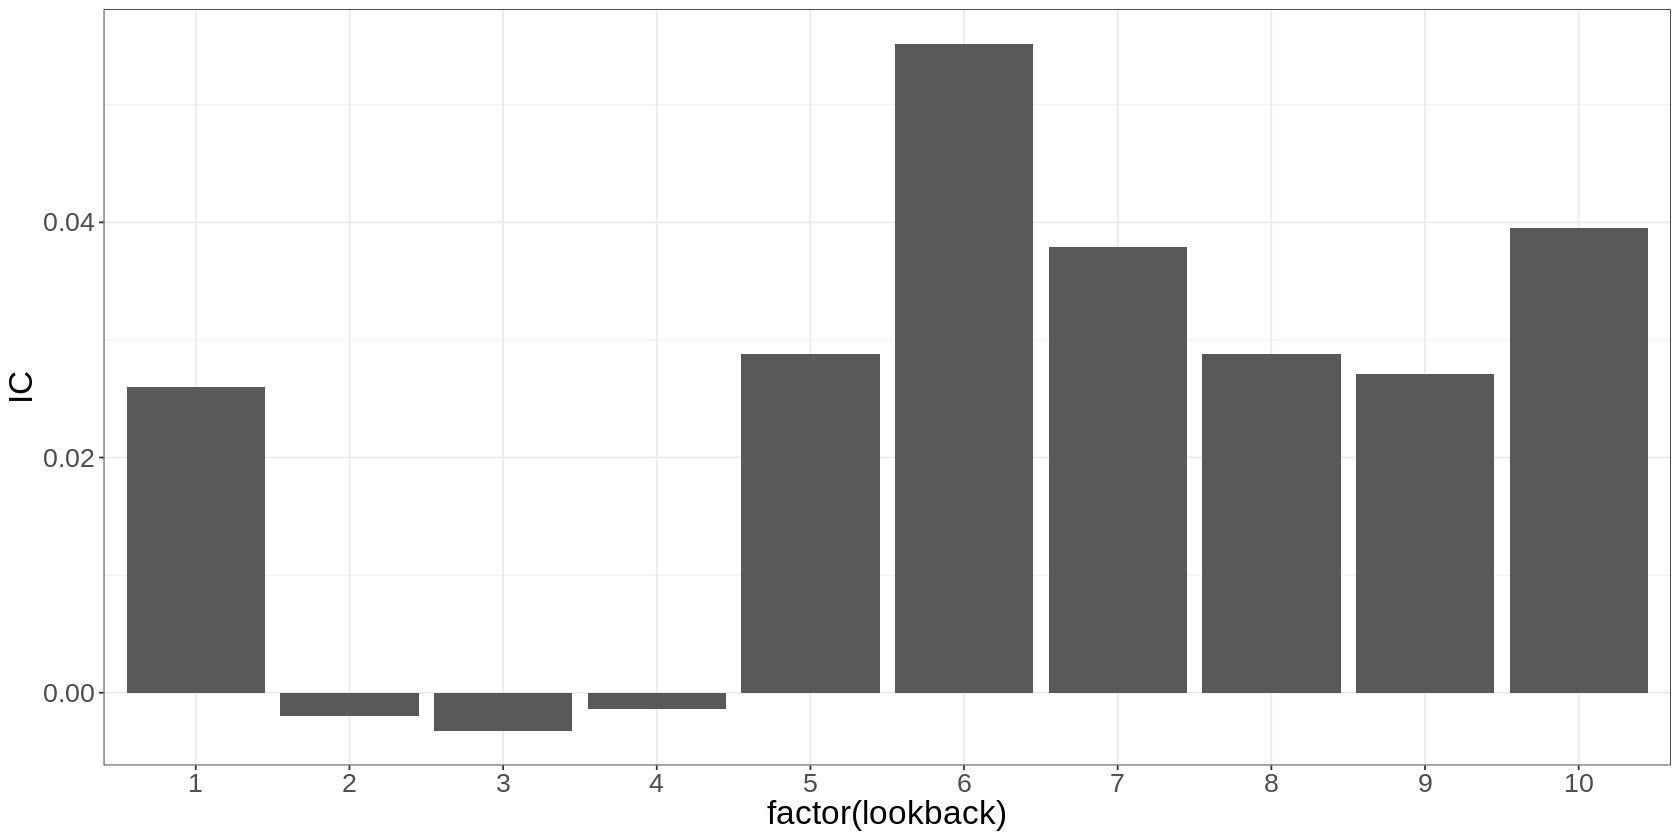

In [13]:
multiple_factors %>%
    select(-ticker,-date,-market_cap,-price_usd) %>%
    pivot_longer("1":"10", names_to = "lookback", values_to = "factor") %>%
    mutate(lookback = as.numeric(lookback)) %>%
    group_by(lookback) %>%
    summarise(IC = cor(factor,target)) %>%
    ggplot(aes(x = factor(lookback), y = IC)) + 
    geom_bar(stat='identity')

So this plot actually tells us that our inital factor wasn't that stable, or you can read this as, our initial factor is sensitive to its timing.

What you're looking for here is areas around your factor specifications to be in the same general level, you don't want a random looking plot, as that might mean that we were lucky in picking something that just happens to work.  